In [1]:
import json
import os
import numpy as np
import scipy.ndimage
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random

# Define base directory for your data
base_dir = 'k:/HSI/'

# Load the JSON files
def load_data(file_path):
    with open(file_path) as f:
        return json.load(f)

data_train = load_data('k:/HSI/train_only_labeled_v2.json')

# Map ripeness states to numerical labels
ripeness_map = {
    "unripe": 0,
    "perfect": 1,
    "overripe": 2
}

# Function to read the binary data
def read_bin_file(bin_file_path, hdr_file_path):
    try:
        with open(hdr_file_path, 'r') as f:
            for line in f:
                if "samples" in line:
                    width = int(line.split('=')[-1].strip())
                elif "lines" in line:
                    height = int(line.split('=')[-1].strip())
                elif "bands" in line:
                    bands = int(line.split('=')[-1].strip())

        bin_path = os.path.join(base_dir, bin_file_path)
        with open(bin_path, 'rb') as f:
            data = np.fromfile(f, dtype=np.float32)
        data = data.reshape((height, width, bands))
        
        return data
    
    except FileNotFoundError as e:
        print(f"File not found: {e.filename}")
        return None

# Function to resize hyperspectral data to a consistent shape
def resize_hyperspectral_data(data, target_shape=(64, 64, 224)):
    current_shape = data.shape
    if current_shape != target_shape:
        zoom_factors = [target_shape[i] / current_shape[i] for i in range(3)]
        resized_data = scipy.ndimage.zoom(data, zoom_factors, order=1)
        return resized_data
    return data

# Function to extract features and labels
def extract_features_and_labels(data, annotations_dict, X_list, y_ripeness_list):
    for record in data['records']:
        if record['fruit'].lower() == "kaki":
            bin_file = record['files']['data_file']
            hdr_file = record['files']['header_file']
            record_id = record['id']
            
            # Load and resize hyperspectral data
            hyperspectral_data = read_bin_file(bin_file, hdr_file)
            if hyperspectral_data is None:
                continue
            
            hyperspectral_data = resize_hyperspectral_data(hyperspectral_data)
            X_list.append(hyperspectral_data)

            # Get ripeness annotation
            if record_id in annotations_dict:
                ripeness_state = annotations_dict[record_id]['ripeness_state']
                y_ripeness_list.append(ripeness_map[ripeness_state])
            else:
                print(f"Warning: No annotation found for record_id {record_id}")

# Prepare training data
annotations_dict_train = {annot['record_id']: annot for annot in data_train['annotations']}
X, y_ripeness = [], []
extract_features_and_labels(data_train, annotations_dict_train, X, y_ripeness)

# Convert to numpy arrays
X = np.array(X)
y_ripeness = np.array(y_ripeness)

# One-hot encode the ripeness labels
y_ripeness = to_categorical(y_ripeness, num_classes=3)

# Function to augment a single hyperspectral image by applying random transformations
def augment_image(data):
    if random.choice([True, False]):
        data = np.flip(data, axis=0)  # Flip vertically
    if random.choice([True, False]):
        data = np.flip(data, axis=1)  # Flip horizontally
    if random.choice([True, False]):
        data = scipy.ndimage.rotate(data, angle=random.randint(-20, 20), axes=(0, 1), reshape=False)
    if random.choice([True, False]):
        shift = random.uniform(-0.1, 0.1)
        data = scipy.ndimage.shift(data, shift=[shift, shift, 0], mode='nearest')
    
    return data

# Function to balance classes using augmentation
def balance_classes(X, y, target_count=84):
    X_balanced, y_balanced = [], []
    for class_label in range(3):  # For each class label
        class_indices = np.where(np.argmax(y, axis=1) == class_label)[0]
        current_count = len(class_indices)
        print("i am in")
        # Add original samples for the class
        for idx in class_indices:
            X_balanced.append(X[idx])
            y_balanced.append(y[idx])
        
        # Generate augmented samples if the current count is less than the target count
        if current_count < target_count:
            augment_needed = target_count - current_count
            for _ in range(augment_needed):
                original = X[random.choice(class_indices)]
                augmented = augment_image(original)
                X_balanced.append(augmented)
                y_balanced.append(to_categorical(class_label, num_classes=3))
    
    return np.array(X_balanced), np.array(y_balanced)

# Balance the classes
target_count = max(np.count_nonzero(y_ripeness == 1), 84)  # Setting target as the highest count among classes
X_balanced, y_balanced = balance_classes(X, y_ripeness, target_count=target_count)
print(y_balanced)
# Train-test split on the balanced dataset
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Print the shapes to verify
print("Shapes after balancing:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)


i am in
i am in
i am in
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Shapes after balancing:
X_train: (268, 64, 64, 224)
y_train: (268, 3)
X_val: (68, 64, 64, 224)
y_val: (68, 3)


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Flatten the hyperspectral data for Random Forest (reshape to 2D)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Standardize the data
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)

# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, np.argmax(y_train, axis=1))  # Convert one-hot to class labels for training

# Predict on the validation set
y_val_pred = rf_model.predict(X_val_flat)
y_val_true = np.argmax(y_val, axis=1)  # Convert one-hot to class labels for evaluation

# Evaluate the model
accuracy = accuracy_score(y_val_true, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_val_true, y_val_pred))



Validation Accuracy: 0.8971
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       0.78      0.90      0.84        20
           2       0.94      0.77      0.85        22

    accuracy                           0.90        68
   macro avg       0.90      0.89      0.89        68
weighted avg       0.90      0.90      0.90        68



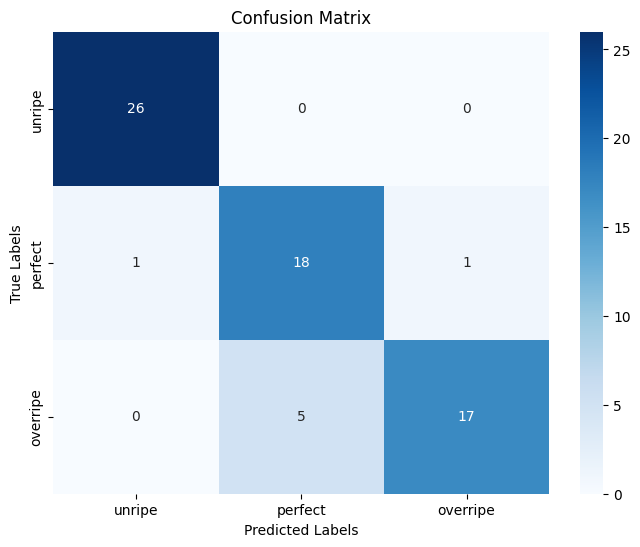

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=ripeness_map.keys(), yticklabels=ripeness_map.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
